In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data
import random

In [2]:
#Utils
def display3DObject(test_object, elev = None, azim = None):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(elev=elev, azim=azim)

    ax.voxels(test_object, edgecolor='k')
    plt.show()
    
def addNoise(shape, noise=0.1):
    #print(shape)
    return Variable(torch.zeros(shape).normal_(0, noise).cuda())

In [3]:
import math
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)

In [4]:
def log_density(sample, mu, logsigma):
    normalization = Variable(torch.Tensor([np.log(2 * np.pi)]), requires_grad = False)
    c = normalization.type_as(sample.data)
    inv_sigma = torch.exp(-logsigma)
    tmp = (sample - mu) * inv_sigma
    return -0.5 * (tmp * tmp + 2 * logsigma + c)

In [5]:
# load images
images = np.load('chair_images.npy')
voxels = np.load('chair_voxels.npy')

# preprocessing
preprocessed_images = []
for subimages in images:
    preprocessed_subimages = np.array([(subimage - np.mean(subimage))/np.std(subimage) for subimage in subimages])
    preprocessed_images.append(preprocessed_subimages)
preprocessed_images = np.stack(preprocessed_images)

# reshuffle order
np.random.seed(42)
reseq = np.random.choice(len(images), len(images), replace=False)
preprocessed_images = np.array([preprocessed_images[i] for i in reseq])
voxels = np.array([voxels[i] for i in reseq])

train_images = preprocessed_images[:-130]
val_images = preprocessed_images[-130:-100]
test_images = preprocessed_images[-100:]
train_voxels = voxels[:-130]
val_voxels = voxels[-130:-100]
test_voxels = voxels[-100:]

Displaying the object


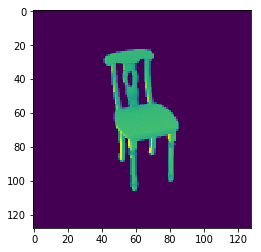

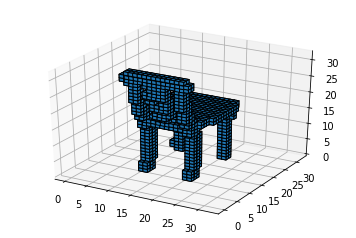

In [6]:
display_id = 56
batch_size = 1
train_data = [train_voxels, train_images]
for _ in range(len(train_data)):
    train_data[_] = torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
plt.imshow(train_images[display_id][0])
display3DObject(train_voxels[display_id])

In [7]:
def testValues():
    eps = 1e-8
    test_last_data = []
    for i in range(len(test_images)):
        test_image = Variable(torch.FloatTensor(test_images[i:i+1])).cuda()
        test_image = test_image[0][0:12].view(12,1,1,128,128)
        test_voxel = Variable(torch.FloatTensor(test_voxels[i])).cuda()
        test_object, _, _ = mvrnn(test_image, 12)
        last_object = test_object[11].squeeze()
        logpx =((last_object+eps).log()*(test_voxel) + (1-last_object+eps).log()*(1-test_voxel)).sum(dim=-1).sum(-1).sum(-1)
        last_rec_loss = -logpx.mean().data.cpu().numpy()
        test_last_data.append(last_rec_loss[0])
    #print(test_last_data)
    return np.mean(test_last_data)

In [8]:
class VAE(nn.Module):
    def __init__(self, input_nc=1, z_size=200, ndf=25, cube_size=32):
        super(VAE, self).__init__()
        self.encoderLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.encoderLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.encoderLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.encoderLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.fc1 = nn.Linear(ndf*8, self.z_size)
        self.fc2 = nn.Linear(ndf*8, self.z_size)
        
        self.decoderLayer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.decoderLayer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.decoderLayer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.decoderLayer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def encoder(self, x): 
        out = self.encoderLayer1(x)
        out = self.encoderLayer2(out)
        out = self.encoderLayer3(out)
        out = self.encoderLayer4(out)
        out = self.encoderLayer5(out)
        out = self.encoderLayer6(out).view(-1, self.z_size)
        return self.fc1(out), self.fc2(out)
    
    #source: https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, x):
        out = self.decoderLayer1(x)
        out = self.decoderLayer2(out)
        out = self.decoderLayer3(out)
        out = self.decoderLayer4(out)
        return out
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        latent = self.reparametrize(mu,sigma)
        latent = latent.view(-1,self.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        
        object_3D = self.decoder(latent)
        return object_3D, mu, sigma
        

In [9]:
class aggregator(nn.Module):
    def __init__(self, input_size = 400,  z_size=200, h_dim=200, n_layers=1, batch_size=1):
        super(aggregator, self).__init__()
        self.h_dim, self.h_dim, self.n_layers= z_size, h_dim, n_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=h_dim, num_layers=n_layers)
        self.hidden_to_z_size = nn.Linear(self.h_dim, z_size)
        self.reInitialize(batch_size)
        
    def reInitialize(self, batch_size):
        self.hidden = (Variable(torch.zeros(self.n_layers,batch_size,self.h_dim)).cuda(), Variable(torch.zeros(self.n_layers,batch_size,self.h_dim)).cuda())
    
    def getInitial(self,batch_size):
        return (Variable(torch.zeros(self.n_layers,batch_size,self.h_dim)).cuda(), Variable(torch.zeros(self.n_layers,batch_size,self.h_dim)).cuda())
    
    def setHiddenState(self, hidden):
        self.hidden = hidden
        
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        output_state = self.hidden_to_z_size(lstm_out[0,0,:])
        current_state = lstm_out[0,0,:]
        return current_state, self.hidden

In [10]:
class controller(nn.Module):
    def __init__(self, input_size = 400, z_size=200, hidden_size = 100):
        super(controller, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size,  z_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        return self.fc2(out)

In [11]:
class MVRNN(nn.Module):
    def __init__(self, z_size=200, batch_size=1):
        super(MVRNN, self).__init__()
        self.z_size = z_size
        self.batch_size = batch_size
        self.vae = VAE()
        self.agg = aggregator()
        self.cont = controller()
        
    def forward(self, x, seqn):
        # x is [Sequence, Batch, channel, h, w]
        current_state = None
        predicted = [] 
        mus = []
        sigmas = []
        states = []
        objects =[]
        self.agg.reInitialize(self.batch_size)
        last_action = Variable(torch.zeros(1,1,200)).cuda()
        for i in range(seqn):
            #print(i)
            mu, sigma= self.vae.encoder(x[i])
            mus.append(mu)
            sigmas.append(sigma)
            latent = self.vae.reparametrize(mu,sigma)
            latent = latent.view(1,self.batch_size,self.z_size)
            memory_input = torch.cat([latent] + [last_action],dim=-1)
#             print(memory_input.shape)
            predicted_state, memory_hidden = self.agg.forward(memory_input)
            self.agg.setHiddenState(memory_hidden)
            #print(predicted_state.shape)
            controller_input = torch.cat((predicted_state, latent.squeeze()), dim=-1)
            #print(controller_input.shape)
            latent_3d = self.cont.forward(controller_input)
            #print(latent_3d.shape)
            states.append(latent_3d)
            #print("Latent Shape", current_state.shape)
            latent_3d = latent_3d.view(-1,self.z_size,1,1,1)
            last_action = latent_3d.view(1,1,200)
            #print(last_action.shape)
            object_3D = self.vae.decoder(latent_3d)
            objects.append(object_3D)
        return objects, mus, sigmas
            
        

In [12]:
mvrnn = MVRNN().cuda()

In [13]:
lr_vae = 0.0003
lr_d = 0.001
adam_beta_vae = (0.5, 0.5)
adam_beta_d = (0.5, 0.5)
mvrnn_solver = optim.Adam(mvrnn.parameters(), lr=lr_vae, betas = adam_beta_vae)

In [ ]:
#Training the mvcnn arch 
num_epochs = 500
max_seq_len = 12
val_images = torch.FloatTensor(val_images)
val_voxels = torch.FloatTensor(val_voxels)
loss = nn.BCELoss(size_average=False)
last_view_loss = []
for epoch in range(num_epochs):
    mvvae_losses = []
    klds = []
    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        seq_len = 12#random.randint(1,max_seq_len-1)
        var_3D_data = Variable(data3d).cuda().float()
        var_2D_data = Variable(data2d).cuda().float().view(max_seq_len,1,1,128,128)
        generated_objects, mus, logvars = mvrnn(var_2D_data, seq_len)
        loss_ = 0
        KLD = 0 
        for i in range(seq_len):
            
            #print(var_3D_data.shape)
                # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #         KLD_element = mu.pow(2).add_(sigma.exp()).mul_(-1).add_(1).add_(sigma)
    #         KLD = torch.sum(KLD_element).mul_(-0.5)
            # https://arxiv.org/abs/1312.6114
            #print(logvar.shape)
            kld =  -0.5 * torch.sum(1 + logvars[i] - mus[i].pow(2) - logvars[i].exp())
            #rint(KLD)
            generated_object = generated_objects[i].squeeze()
            loss_ = loss_+ loss(generated_object, var_3D_data.squeeze()) + kld
            KLD = KLD + kld
        mvrnn.zero_grad()
        loss_.backward()
        mvrnn_solver.step()
        mvvae_losses.append(loss_)
        klds.append(KLD)
#     random_val = random.randint(1,10-1)
#     seq_len = random.randint(1,max_seq_len-1)
#     val_3D_data = Variable(val_voxels[random_val]).cuda().float()
#     val_2D_data = Variable(val_images[random_val]).cuda().float().view(max_seq_len,1,1,128,128)
#     generated_object_val, mu, sigma = mvrnn(val_2D_data,seq_len)
#     generated_object_val = torch.round(generated_object_val.squeeze())
#     accuracy = np.mean((generated_object_val  == val_3D_data.squeeze()).squeeze().data.cpu().numpy())
    mvvae_losses_mean = np.mean(np.concatenate(mvvae_losses))
    kld_mean =  np.mean(np.concatenate(klds)).data.cpu().numpy()[0]
    print("Epoch: ", epoch, '\n', "MV RNN loss: ", mvvae_losses_mean.data.cpu().numpy()[0])
    print( "KLD loss: ", kld_mean) #"Accuracy", accuracy,
    if (epoch+1)%1 == 0:
        test_average = testValues()
        print("Epoch " + str(epoch) + "  " +str(test_average))
        last_view_loss.append("Epoch " + str(epoch) + "  " +str(test_average))
        torch.save(mvrnn.state_dict(), 'lstm_vae_444_' + str(epoch)+ '.pt')
        print("Saving model")

Epoch:  0 
 MV RNN loss:  69984.82
KLD loss:  162.27325
Epoch 0  4829.7573
Saving model
Epoch:  1 
 MV RNN loss:  53101.57
KLD loss:  307.34213
Epoch 1  4039.171
Saving model
Epoch:  2 
 MV RNN loss:  51017.652
KLD loss:  339.25842
Epoch 2  4011.7534
Saving model
Epoch:  3 
 MV RNN loss:  48868.137
KLD loss:  371.16138
Epoch 3  3942.3357
Saving model
Epoch:  4 
 MV RNN loss:  48354.027
KLD loss:  381.97028
Epoch 4  3750.1729
Saving model
Epoch:  5 
 MV RNN loss:  47241.586
KLD loss:  387.8565
Epoch 5  3803.3223
Saving model
Epoch:  6 
 MV RNN loss:  46336.84
KLD loss:  400.54868
Epoch 6  3806.587
Saving model
Epoch:  7 
 MV RNN loss:  45924.01
KLD loss:  420.24997
Epoch 7  3606.78
Saving model
Epoch:  8 
 MV RNN loss:  45026.24
KLD loss:  450.74384
Epoch 8  3615.6626
Saving model
Epoch:  9 
 MV RNN loss:  44019.555
KLD loss:  473.68484
Epoch 9  3660.6487
Saving model
Epoch:  10 
 MV RNN loss:  43185.516
KLD loss:  482.74826
Epoch 10  3547.6597
Saving model
Epoch:  11 
 MV RNN loss:  42

Epoch 91  3718.056
Saving model
Epoch:  92 
 MV RNN loss:  25197.889
KLD loss:  875.56866
Epoch 92  3495.372
Saving model
Epoch:  93 
 MV RNN loss:  25023.201
KLD loss:  847.57104
Epoch 93  3514.008
Saving model
Epoch:  94 
 MV RNN loss:  25185.133
KLD loss:  847.9568
Epoch 94  3598.3496
Saving model
Epoch:  95 
 MV RNN loss:  24984.855
KLD loss:  855.36285
Epoch 95  3650.083
Saving model
Epoch:  96 
 MV RNN loss:  24901.877
KLD loss:  861.50165
Epoch 96  3817.2273
Saving model
Epoch:  97 
 MV RNN loss:  24853.158
KLD loss:  866.3855
Epoch 97  3426.0654
Saving model
Epoch:  98 
 MV RNN loss:  24716.982
KLD loss:  863.7967
Epoch 98  4004.3035
Saving model
Epoch:  99 
 MV RNN loss:  24653.725
KLD loss:  861.9749
Epoch 99  3746.4421
Saving model
Epoch:  100 
 MV RNN loss:  24515.846
KLD loss:  863.9358
Epoch 100  3620.7854
Saving model
Epoch:  101 
 MV RNN loss:  24421.662
KLD loss:  869.34607
Epoch 101  3512.8423
Saving model
Epoch:  102 
 MV RNN loss:  24381.916
KLD loss:  869.00934
Epo

In [32]:
last_view_loss

['Epoch 0  4752.857', 'Epoch 1  4100.709']

In [ ]:
# #Testing the mvcnn architecture 

# mvcn = mvcnn().cuda()

#print(val_images[1:2])
i = random.randint(0,100) #3211
seq = 12
test_image = Variable(torch.FloatTensor(test_images[i:i+1])).cuda()
test_image = test_image[0][0:seq].view(seq,1,1,128,128)
print(test_image.shape)
# #test_image = test_image[0][0:1].unsqueeze(1)
# print(test_image.shape) 

test_object, _, _ = mvrnn(test_image, seq)

plt.imshow(test_images[i][0])
# display3DObject(Variable(voxels[i]).data.cpu().numpy())
display3DObject(test_voxels[i])
display3DObject(test_object[0].squeeze().data.cpu().numpy()>0.5)
display3DObject(test_object[6].squeeze().data.cpu().numpy()>0.5)
display3DObject(test_object[11].squeeze().data.cpu().numpy()>0.5)

In [35]:
seq = 12
def testValues():
    eps = 1e-8
    test_last_data = []
    for i in range(len(test_images)):
        test_image = Variable(torch.FloatTensor(test_images[i:i+1])).cuda()
        test_image = test_image[0][0:seq].view(seq,1,1,128,128)
        test_voxel = Variable(torch.FloatTensor(test_voxels[i])).cuda()
        test_object, _, _ = mvrnn(test_image, 12)
        last_object = test_object[11].squeeze()
        logpx =((last_object+eps).log()*(test_voxel) + (1-last_object+eps).log()*(1-test_voxel)).sum(dim=-1).sum(-1).sum(-1)
        last_rec_loss = -logpx.mean().data.cpu().numpy()
        test_last_data.append(last_rec_loss[0])
    #print(test_last_data)
    return np.mean(test_last_data)
print(testValues())

4181.9824


In [ ]:
# test: single sample vs multiview greeedy vs multiview probabilistic
for epoch in range(199,300, 5):
    avg_singleview_rec_losses = []
    best_singleview_rec_losses = []
    multiview_greedy_rec_losses = []
    sigma_list = []
    greedy_sigma_list = []

    for i in range(len(test_data)):
        data3d, data2d = test_data[0][i], test_data[1][i]
        data2d = data2d.unsqueeze(1)

        var_3D_data = Variable(data3d.cuda().float(), requires_grad=False).unsqueeze(0)
        var_2D_data = Variable(data2d.cuda().float(), requires_grad=False)
        mu, logsigma = vae.encoder(var_2D_data)

        # single view reconstructions
        zs = mu
        x_params = vae.decoder(zs.view(-1,z_size,1,1,1))
        x_params = x_params.squeeze()
        
        
        loss, elbo_term, logpx, mutinfo, total_cor, dim_kl = elbo(var_3D_data.expand(data2d.size(0), -1, -1, -1), \
                                                                  x_params, \
                                                                  zs, mu, logsigma,  \
                                                                  dataset_size, tcvae = True, beta=Beta, \
                                                                  lamb = 0, include_mutinfo= True)
        
        avg_rec_loss = -logpx.mean().data.cpu().numpy()[0]
        best_rec_loss = -np.max(logpx.data.cpu().numpy())
    
        sigma_mean = logsigma.exp().mean().data.cpu().numpy()
        avg_singleview_rec_losses.append(avg_rec_loss)
        best_singleview_rec_losses.append(best_rec_loss)
        sigma_list.append(sigma_mean)

        # multiview greedy
        greedy_indices = torch.min(logsigma, dim=0)[1]
        mu = mu.gather(0, greedy_indices.view(1,-1))
        logsigma = logsigma.gather(0, greedy_indices.view(1,-1))
        zs = mu.view(-1,vae.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        x_params = vae.decoder(zs)
        x_params = x_params.squeeze().unsqueeze(0)
        
        loss, elbo_term, logpx, mutinfo, total_cor, dim_kl = elbo(var_3D_data.expand(data2d.size(0), -1, -1, -1), \
                                                          x_params, \
                                                          zs, mu, logsigma,  \
                                                          dataset_size, tcvae = True, beta=Beta, \
                                                          lamb = 0, include_mutinfo= True)
        
        
        greedy_rec_loss = -logpx.data.cpu().numpy()[0]
        greedy_sigma = logsigma.exp().mean().data.cpu().numpy()
        
        multiview_greedy_rec_losses.append(greedy_rec_loss)
        greedy_sigma_list.append(greedy_sigma)

    sigma_list = np.stack(sigma_list)
    greedy_sigma_list = np.stack(greedy_sigma_list)

    print('epoch', epoch)
    print('single view sigma', np.mean(sigma_list))
    print('single view average', sum(avg_singleview_rec_losses)/len(avg_singleview_rec_losses))
    print('single view best', sum(best_singleview_rec_losses)/len(best_singleview_rec_losses))
    print('multiview greedy sigma', np.mean(greedy_sigma_list))
    print('multiview greedy', sum(multiview_greedy_rec_losses)/len(multiview_greedy_rec_losses))